In [222]:
import pandas as pd
import json,csv
import numpy as np
import sqlalchemy
import datetime as dt
from datetime import timedelta
from sqlalchemy import create_engine, MetaData,inspect,func
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import Column, Integer, String, Numeric, Text, Float
from sqlalchemy.orm import Session 
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
pymysql.install_as_MySQLdb()

In [223]:
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [224]:
Base = automap_base()

In [225]:
Base.prepare(engine, reflect=True)

In [226]:
Base.classes.keys() 

['measurements', 'stations']

In [227]:
engine.execute("select * from measurements")

In [228]:
inspector=inspect(engine)

In [229]:
columns = inspector.get_columns('measurements')
for column in columns:
    print(column["name"])

id
station
date
prcp
tobs


In [230]:
inspector.get_table_names()

['measurements', 'stations']

In [231]:
Station = Base.classes.stations
Measurements = Base.classes.measurements

In [232]:
session = Session(engine)

### Percipitaion Analysis

In [233]:
first_date=session.query(Measurements.date).first()
first_date

('2010-01-01')

In [234]:
one_year=session.query(Measurements.date,Measurements.prcp).\
    filter(Measurements.date >= '2010-01-01' , Measurements.date < '2011-01-01').all()

In [235]:
oneYear_df = pd.DataFrame(one_year)
oneYear_df.head()

,date,prcp
0,2010-01-01,0.08
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
4,2010-01-07,0.06


In [236]:
oneYear_df.set_index('date', inplace=True)
oneYear_df.head()

,prcp
date,
2010-01-01,0.08
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-07,0.06


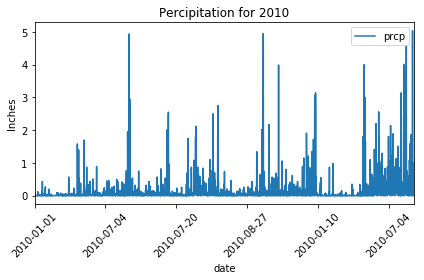

In [311]:
oneYear_df.plot(x_compat=True)
plt.xticks(rotation='45')
plt.title('Percipitation for 2010')
plt.ylabel('Inches')
plt.tight_layout()
plt.savefig('prcp_analysis')
plt.show()

In [238]:
summary_statistics= oneYear_df.describe()
summary_statistics

,prcp
count,2681.000000
mean,0.138523
std,0.411995
min,0.000000
25%,0.000000
50%,0.010000
75%,0.090000
max,5.040000


## Station Analysis

In [239]:
count_of_stations= session.query(Station.station).count()
count_of_stations

9

In [240]:
prcpperstation = session.query(Measurements.station, func.sum(Measurements.prcp)).group_by(Measurements.station).order_by(func.sum(Measurements.prcp).desc()).all()
prcpperstation

[('USC00516128', 1068.0899999999956),
 ('USC00519281', 588.6399999999976),
 ('USC00513117', 382.61999999999847),
 ('USC00519523', 295.67999999999944),
 ('USC00514830', 234.49000000000026),
 ('USC00519397', 131.62000000000063),
 ('USC00511918', 92.68000000000006),
 ('USC00518838', 70.87000000000005),
 ('USC00517948', 43.44000000000002)]

In [241]:
topStation=prcpperstation[0]
topStation

('USC00516128', 1068.0899999999956)

In [253]:
Most_obs=session.query(Station.name).filter_by(station=topStation[0]).all()
Most_obs

[('MANOA LYON ARBO 785.2, HI US')]

In [254]:
tobsperstation=pd.DataFrame(session.query(Measurements.station,Measurements.tobs,Measurements.date).filter(Measurements.station=='USC00516128').filter(Measurements.date >= '2010-01-01' , Measurements.date < '2011-01-01').all())
tobsperstation.head()


,station,tobs,date
0,USC00516128,73,2010-01-01
1,USC00516128,61,2010-01-02
2,USC00516128,76,2010-01-03
3,USC00516128,72,2010-01-04
4,USC00516128,74,2010-01-05


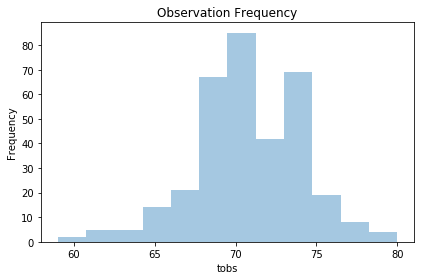

In [314]:
sns.distplot(a=tobsperstation["tobs"],bins=12, hist=True, kde=False, rug=False )
plt.ylabel('Frequency')
plt.title('Observation Frequency')
plt.tight_layout()
plt.savefig('station_analysis')
plt.show()

## Temperature Analysis

In [279]:
fd='2013-1-10'
ld='2013-1-15'
first_day =(pd.to_datetime(fd,format='%Y-%m-%d')-dt.timedelta(days=365)).strftime('%Y-%m-%d')
last_day =(pd.to_datetime(ld,format='%Y-%m-%d')-dt.timedelta(days=365)).strftime('%Y-%m-%d')


In [280]:
last_day

'2012-01-16'

In [281]:
def calc_temps(first_day,last_day):
    _max = session.query(func.max(Measurements.tobs)).filter(Measurements.date>first_day)\
        .filter(Measurements.date<last_day).all()
    _min = session.query(func.min(Measurements.tobs)).filter(Measurements.date>first_day)\
        .filter(Measurements.date<last_day).all()
    _avg = session.query(func.avg(Measurements.tobs)).filter(Measurements.date>first_day)\
        .filter(Measurements.date<last_day).all()
        
    
    return _max,_min,round(_avg,2)
    

In [294]:
max_temp,min_temp,avg_temp = calc_temps(first_day,last_day)
max_temp=max_temp[0][0]
min_temp=min_temp[0][0]
avg_temp=avg_temp[0][0]


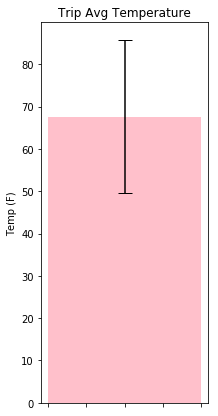

In [298]:
fig, ax = plt.subplots(figsize=(3,7))
ax.bar(1, avg_temp, color = 'pink', yerr=(max_temp-min_temp), capsize=7)
ax.set_xticklabels([])
plt.yticks(np.arange(0, avg_temp+20, 10))
plt.title ("Trip Avg Temperature")
plt.ylabel ("Temp (F)")
plt.savefig('temp_analysis')
plt.show()
   
    

## Flask App

In [307]:
app = Flask(__name__)

In [308]:
@app.route("/api/v1.0/precipitation")
def tobs():
    tobs={}
    query1=tobsperstation[(tobsperstation.date >= str(2010-1-1)) & (tobsperstation.date <= str(2011-1-1))].groupby('station','date').sum()  
    for index, row in tobsperstation.iterrows():
        tobs[row.date] = row.tobs
    return jsonify(tobs)

@app.route("/api/v1.0/stations")
def stationNames():
    results = tobsperstation[(tobsperstation.station)]
    return jsonify(station_names)

# @app.route("/api/v1.0/tobs")
# def tobs():



if __name__ == '__main__':
	app.run(debug=True)







OSError: [Errno 48] Address already in use